<a href="https://colab.research.google.com/github/ankesh86/IntroductionToMachineLearning/blob/main/ASSGN_q3_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas


In [ ]:
import pandas as pd

wine_df = pd.read_csv("sample_data/winequality-white.csv", sep=';')

In [ ]:
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [ ]:
wine_df["quality"].unique()

array([6, 5, 7, 8, 4, 3, 9])

In [ ]:
label = "quality"
features_df = wine_df.drop(columns=['quality'])

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing


In [ ]:
def regularized_cov(X, lambda_reg):
    # Note: Ensure the input X is in the form where rows are observations
    sigma = np.cov(X, rowvar=False)  # rowvar=False to treat rows as observations
    n_features = X.shape[1]
    sigma += lambda_reg * np.eye(n_features)
    return sigma

In [ ]:
# Access rows/columns by indexing
X = wine_df.iloc[:, :-1].to_numpy()
qualities = wine_df.iloc[:, -1].to_numpy()

# Define a label encoder to encode labels numerically
le = preprocessing.LabelEncoder()
labels = le.fit_transform(qualities)  # Fit and transform in one step

# Estimate class priors
class_priors = wine_df['quality'].value_counts(normalize=True).sort_index().to_numpy()
num_classes = len(class_priors)

In [ ]:
# Calculate mean vectors
grouped = wine_df.groupby('quality')
mean_vectors = grouped.mean().to_numpy()

# Regularization parameter
lambda_reg = 1 / wine_df.shape[1]  # Example regularization, can be tuned

# Compute regularized covariance matrices for each class
regularized_cov_matrices = np.array([
    regularized_cov(X[labels == l], lambda_reg)
    for l in range(num_classes)
])

# Number of samples per class
N_per_l = grouped.size().to_numpy()


In [ ]:
gmm = {
    'priors': class_priors,
    'mu': mean_vectors,
    'Sigma': regularized_cov_matrices
}

print(N_per_l)


[  20  163 1457 2198  880  175    5]


In [ ]:
from scipy.stats import norm, multivariate_normal
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# ERM classification rule (min prob. of error classifier IF 0-1 loss)
def perform_erm_classification(X, Lambda, gmm_params, C):
    # Conditional likelihoods of each x given each class, shape (C, N)
    class_cond_likelihoods = np.array([multivariate_normal.pdf(X, gmm_params['mu'][i], gmm_params['Sigma'][i]) for i in range(C)])

    # Take diag so we have (C, C) shape of priors with prior prob along diagonal
    class_priors = np.diag(gmm_params['priors'])
    # class_priors*likelihood with diagonal matrix creates a matrix of posterior probabilities
    # with each class as a row and N columns for samples, e.g. row 1: [p(y1)p(x1|y1), ..., p(y1)p(xN|y1)]
    class_posteriors = class_priors.dot(class_cond_likelihoods)

    # Conditional risk matrix of size C x N with each class as a row and N columns for samples
    risk_mat = Lambda.dot(class_posteriors)

    # If 0-1 loss, you could instead compute MAP result: np.argmax(class_posteriors, axis=0)
    return np.argmin(risk_mat, axis=0)

In [ ]:
!pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.3 MB/s eta 0:00:00


In [ ]:
%matplotlib widget

from sys import float_info  # Threshold smallest positive floating value

import matplotlib.pyplot as plt # For general plotting

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Confusion Matrix (rows: Predicted class, columns: True class):


Text(0.5, 0, 'True Labels')

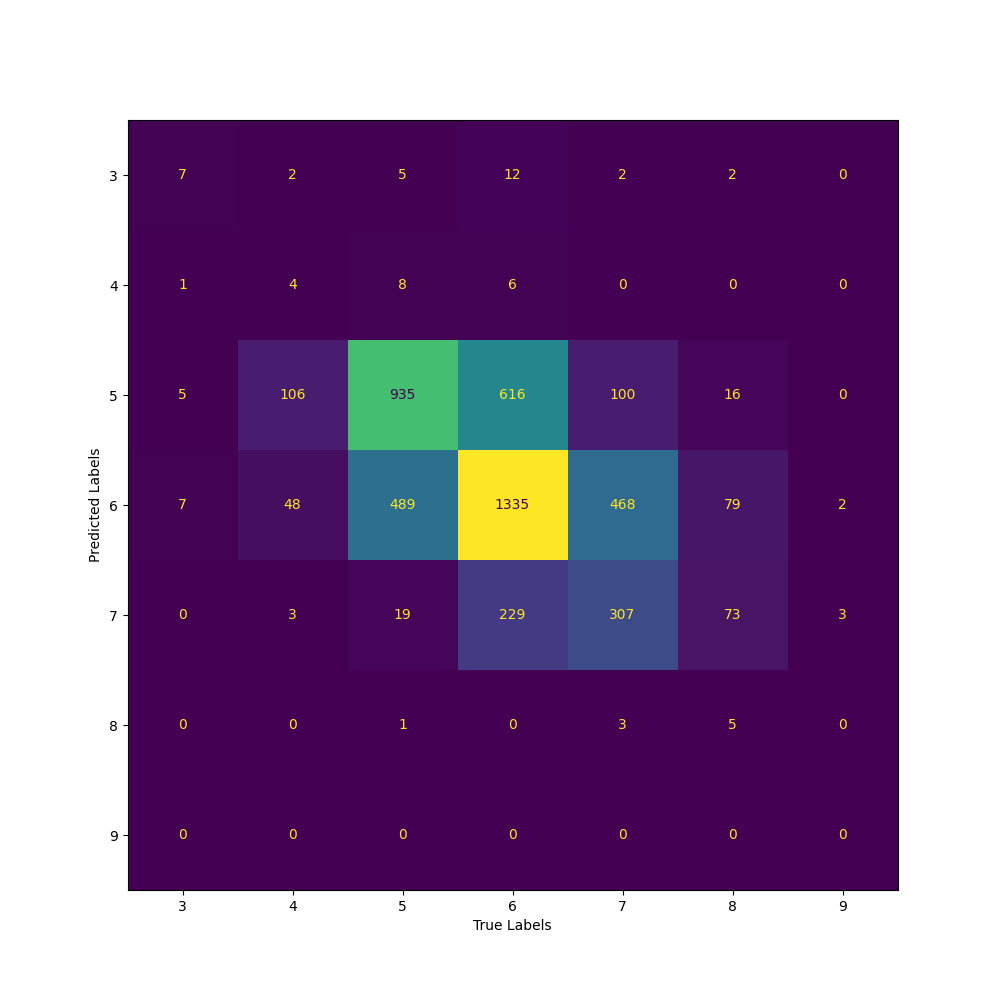

In [ ]:
# If 0-1 loss then yield MAP decision rule, else ERM classifier
Lambda = np.ones((num_classes, num_classes)) - np.eye(num_classes)

# ERM decision rule, take index/label associated with minimum conditional risk as decision (N, 1)
decisions = perform_erm_classification(X, Lambda, gmm, num_classes)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)
fig, ax = plt.subplots(figsize=(10, 10))
conf_display = ConfusionMatrixDisplay.from_predictions(decisions, labels, ax=ax,
                                                       display_labels=['3', '4', '5', '6', '7', '8', '9'], colorbar=False)
plt.ylabel('Predicted Labels')
plt.xlabel('True Labels')



In [ ]:
# Total number of rows/samples
N = len(wine_df.index)

correct_class_samples = np.sum(np.diag(conf_mat))
print("Total number of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

Total number of Misclassified Samples: 2305
Empirically Estimated Probability of Error: 0.4706


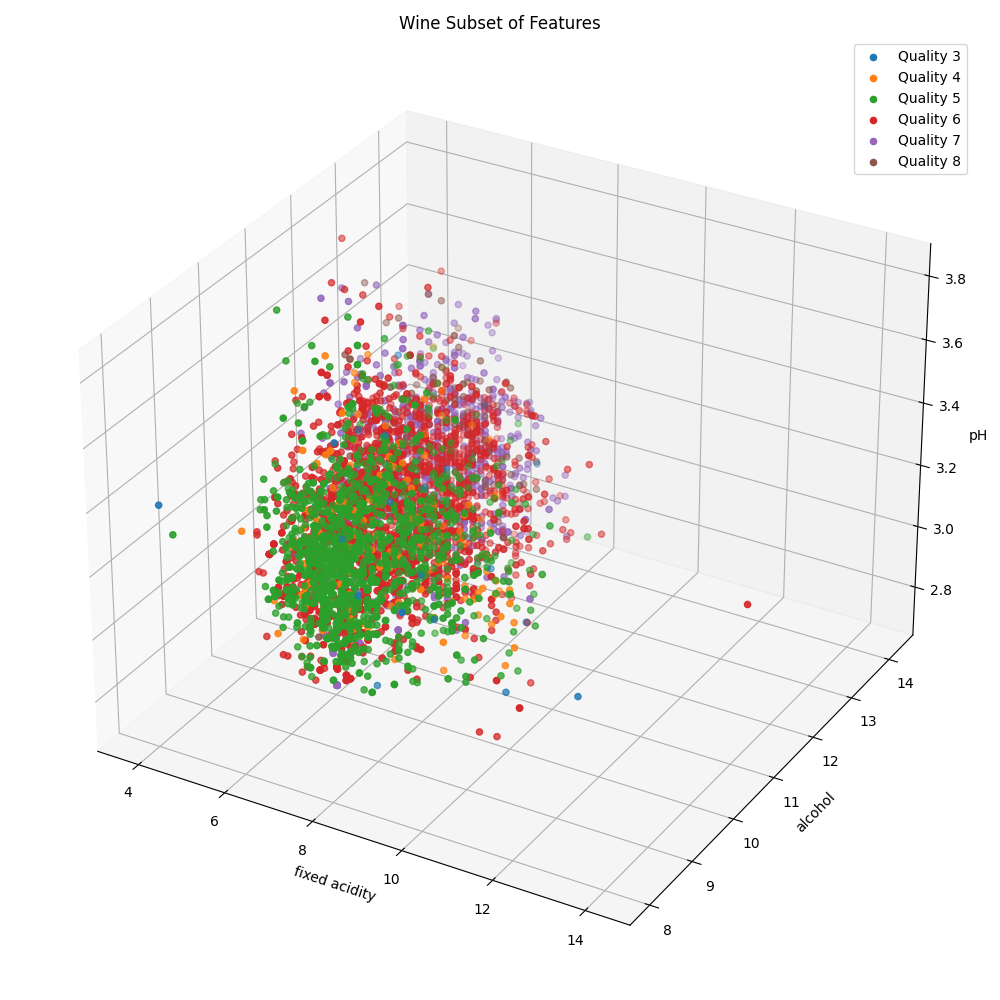

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax_subset = fig.add_subplot(111, projection='3d')

unique_qualities = np.sort(wine_df['quality'].unique())
for q in range(unique_qualities[0], unique_qualities[-1]):
    ax_subset.scatter(wine_df[wine_df['quality']==q]['fixed acidity'],
                      wine_df[wine_df['quality']==q]['alcohol'],
                      wine_df[wine_df['quality']==q]['pH'], label="Quality {}".format(q))

ax_subset.set_xlabel("fixed acidity")
ax_subset.set_ylabel("alcohol")
ax_subset.set_zlabel("pH")

# Set equal axes for 3D plots to realize the additional challenges in visualization
# ax_subset.set_box_aspect((np.ptp(wine_df['fixed acidity']), np.ptp(wine_df['alcohol']), np.ptp(wine_df['pH'])))

plt.title("Wine Subset of Features")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA

Explained variance ratio:  [0.90965734 0.07933386 0.01015427]


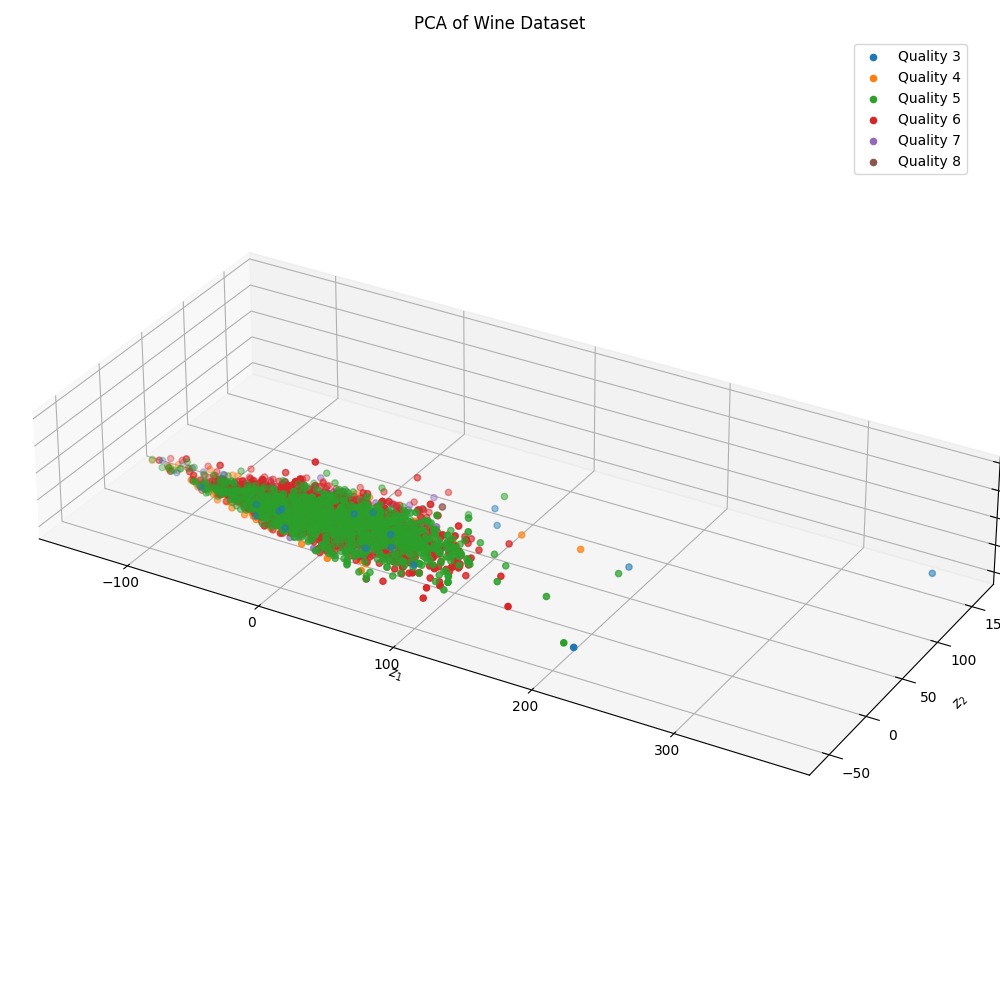

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax_pca = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)  # n_components is how many PCs we'll keep
X_fit = pca.fit(X)  # Is a fitted estimator, not actual data to project
Z = pca.transform(X)

# Illustrates that we have at least 90% of the total variance captured by the PCA
print("Explained variance ratio: ", pca.explained_variance_ratio_)

for q in range(unique_qualities[0], unique_qualities[-1]):
    ax_pca.scatter(Z[wine_df['quality']==q, 0],
                      Z[wine_df['quality']==q, 1],
                      Z[wine_df['quality']==q, 2], label="Quality {}".format(q))

ax_pca.set_xlabel(r"$z_1$")
ax_pca.set_ylabel(r"$z_2$")
ax_pca.set_zlabel(r"$z_3$")

ax_pca.set_box_aspect((np.ptp(Z[:, 0]), np.ptp(Z[:, 1]), np.ptp(Z[:, 2])))

plt.title("PCA of Wine Dataset")
plt.legend()
plt.tight_layout()
plt.show()